In [ ]:
from datetime import datetime, timedelta
import urllib.parse
import time
import yfinance as yf
import pandas as pd
from gdeltdoc import GdeltDoc, Filters
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

To start with we need datasets for both sentiment analysis of news data and stock market data. Im using GDELT to get news and YahooFinance to get stock data
1. GDELT: https://github.com/alex9smith/gdelt-doc-api
2. YahooFinance: https://pypi.org/project/yfinance/

In [ ]:
#Get news data for sentiment analysis

# Define the start and end dates
start_date = datetime(2024, 10, 1)
end_date = datetime(2025, 2, 1)

keywords = ["US election", "Dow Jones", "S&P 500", "Nasdaq", "Trump", "stock market"]
wait_time = 300

for key in keywords:

    encoded_query = urllib.parse.quote(key)

    current_date = start_date
    while current_date <= end_date:

        today = current_date.strftime("%Y-%m-%d")
        tomorrow = (current_date + timedelta(days=1)).strftime("%Y-%m-%d")

        gd = GdeltDoc()

        f = Filters(
        start_date = today,
        end_date = tomorrow,
        num_records = 150,
        keyword = encoded_query,
        country = "US",
        )

        articles = gd.article_search(f)

        df = pd.DataFrame(articles)
        df.to_csv('gdelt_'+key+'.csv', mode='a', header=False, index=False)

        current_date += timedelta(days=1)

    print("\n News data from Gdelt successfully fetched and stored")
    time.sleep(wait_time)


In [ ]:
# Define the indices and their corresponding Yahoo Finance tickers

indices = {
    'Dow_Jones': '^DJI',
    'S&P_500': '^GSPC',
    'Nasdaq': '^IXIC'
}

start_date = '2024-10-01'
end_date = '2025-02-01'

for name, ticker in indices.items():
    print(f"Fetching data for {name} ({ticker})")
    
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h")
    
    filename = f"{name}_Stock_Data.csv"
    df.to_csv(filename)

    print(f"Data saved to {filename}")
    plt.plot(df.index, df['Close'], label=name)

print("\n Stock market data successfully fetched and stored")

plt.title("Stock Market Time Series Data ")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.show()


We now have a news dataset spanning 6 csv files based on keywords - "US election", "Dow Jones", "S&P 500", "Nasdaq", "Trump", "stock market" - from GDELT. This is stored in 6 separate files as each one has huge amount of data stored in them. Lets process the data.
We also have dataset spanning 3 csv files for stock market - "Dow Jones", "Nasdaq", "S&P 500", retrived from YahooFinance. Lets also process this data.

In [187]:
#Lets check news data from GDELT. We can check for one case and then might as well apply the same rules to all the 6 csv files. I will showcase the final method here.

def initial_cleanup(file):
        df = pd.read_csv('dataset_gdelt/'+file+'.csv')
        df.columns = ["url", "url_mobile", "title", "seenDate", "socialImage", "domain", "language", "sourceCountry"]

        #We dont see The columns 'url', 'url_mobile', 'socialimage' adding much value. lets remove them. 
        df.drop(columns=["url", "url_mobile", "socialImage"], inplace=True)

        #Convert seenDate to easily understandable format
        df["seenDate"] = pd.to_datetime(df["seenDate"], format="%Y%m%dT%H%M%SZ")


        return df

In [188]:
df_DJ = initial_cleanup('gdelt_Dow_Jones')
df_nasdaq = initial_cleanup('gdelt_Nasdaq')
df_snp = initial_cleanup('gdelt_S&P_500')
df_stock = initial_cleanup('gdelt_stock_market')
df_trump = initial_cleanup('gdelt_Trump')
df_election = initial_cleanup('gdelt_US_election')

In [189]:
#merge all dataframes 

df_news = pd.concat([df_DJ, df_nasdaq, df_snp, df_stock, df_trump, df_election], ignore_index=True)
df_news.shape

(85513, 5)

In [190]:
#our dataset is ready. Now lets just get basic info about the dataset
print("Dataset Shape:", df_news.shape)
print("\nColumn Info:")
print(df_news.info())

Dataset Shape: (85513, 5)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85513 entries, 0 to 85512
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          85500 non-null  object        
 1   seenDate       85513 non-null  datetime64[ns]
 2   domain         85513 non-null  object        
 3   language       85513 non-null  object        
 4   sourceCountry  85513 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 3.3+ MB
None


In [191]:
#lets now analyse columns
#remove null values

for col in df_news.columns:
    null_count = df_news[col].isnull().sum()
    print(f"Number of null values in column {col}: {null_count}")

Number of null values in column title: 13
Number of null values in column seenDate: 0
Number of null values in column domain: 0
Number of null values in column language: 0
Number of null values in column sourceCountry: 0


In [192]:
#title is the most needed column. Without that we cannot perform sentiment analysis. Lets remove the null values from it. We dont need those rows.
df_news_nonnull = df_news.dropna(subset=["title"])
df_news_nonnull.shape

(85500, 5)

['English' 'Korean' 'Russian' 'Arabic' 'Finnish' 'Japanese' 'Dutch'
 'Danish' 'French' 'Turkish' 'Swedish' 'Icelandic' 'Italian' 'Slovak'
 'German' 'Greek' 'Spanish' 'Macedonian' 'Telugu' 'Chinese' 'Polish'
 'Ukrainian' 'Indonesian' 'Persian' 'Hungarian']


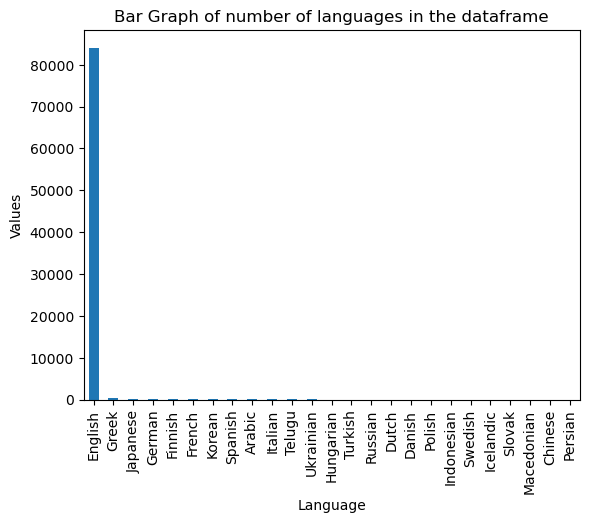

In [193]:
#lets check if we have any other language other than english. For simplicity, lets just have data in english
print(df_news_nonnull['language'].unique())

df_news_nonnull['language'].value_counts().plot(kind='bar')
plt.title('Bar Graph of number of languages in the dataframe')
plt.xlabel('Language')
plt.ylabel('Values')
plt.show()

(84104, 5)


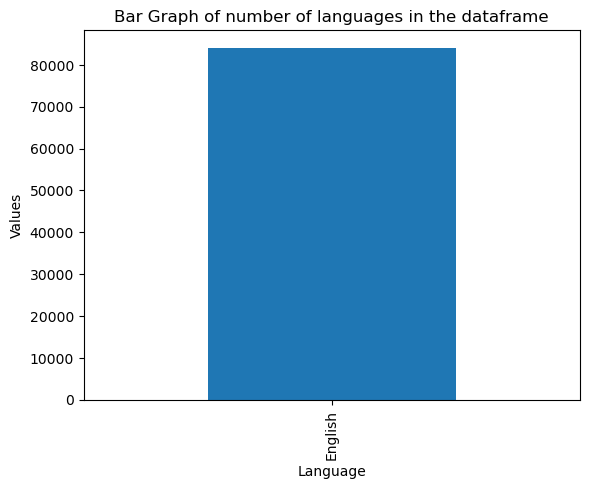

In [194]:
#There are too many languages we dont need. Lets just take a subset of the dataframe with language = english
df_news_nonnull_english = df_news_nonnull[df_news_nonnull['language'] == 'English']
print(df_news_nonnull_english.shape)

df_news_nonnull_english['language'].value_counts().plot(kind='bar')
plt.title('Bar Graph of number of languages in the dataframe')
plt.xlabel('Language')
plt.ylabel('Values')
plt.show()

/var/folders/55/x837yjcj345fvyz78_wh348h0000gn/T/ipykernel_19822/3411084330.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



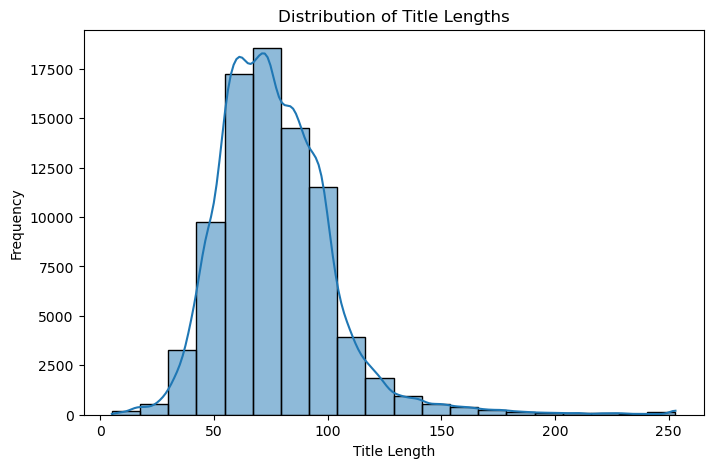

In [195]:
#Lets check title

df_news_nonnull_english["title_length"] = df_news_nonnull_english["title"].apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(df_news_nonnull_english["title_length"], bins=20, kde=True)
plt.title("Distribution of Title Lengths")
plt.xlabel("Title Length")
plt.ylabel("Frequency")
plt.show()

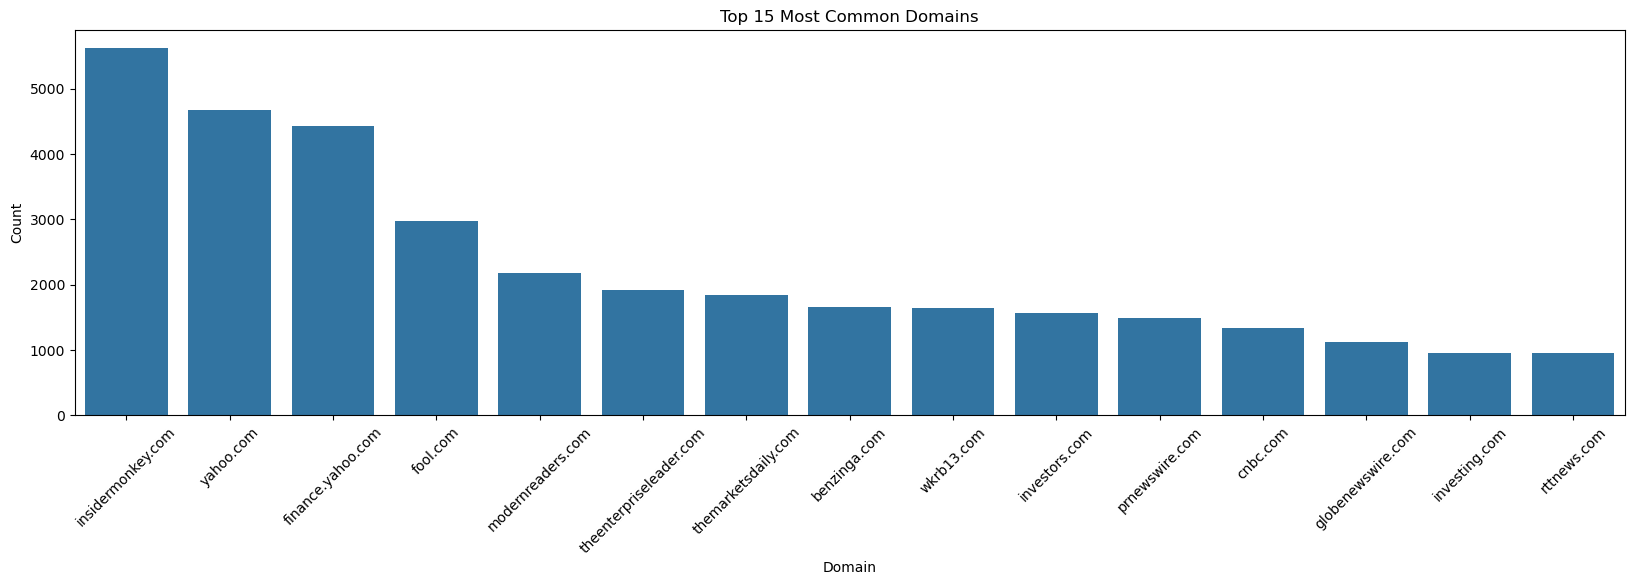

In [196]:
#Now lets check for the most common domains
top_domains = df_news_nonnull_english["domain"].value_counts().head(15)

plt.figure(figsize=(20, 5))
sns.barplot(x=top_domains.index, y=top_domains.values)
plt.xticks(rotation=45)
plt.title("Top 15 Most Common Domains")
plt.xlabel("Domain")
plt.ylabel("Count")
plt.show()

/var/folders/55/x837yjcj345fvyz78_wh348h0000gn/T/ipykernel_19822/2015428998.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



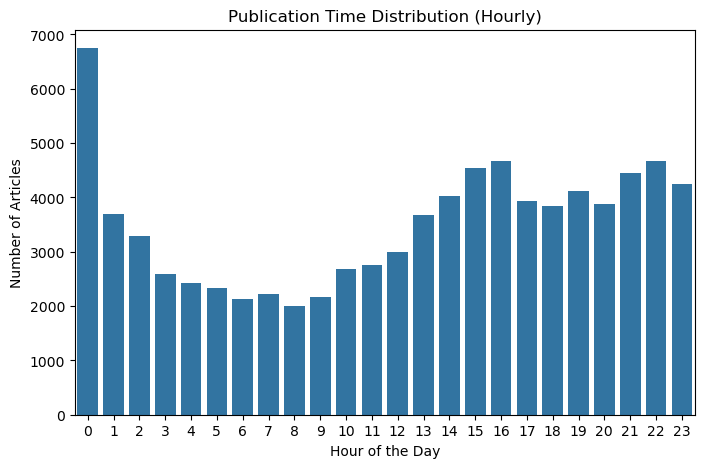

In [197]:
#Lets also check for article publication trends

df_news_nonnull_english["hour"] = df_news_nonnull_english["seenDate"].dt.hour

plt.figure(figsize=(8, 5))
sns.countplot(x=df_news_nonnull_english["hour"], order=sorted(df_news_nonnull_english["hour"].unique()))
plt.title("Publication Time Distribution (Hourly)")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Articles")
plt.show()

Now that we have cleaned dataset, lets start with text processing. note that only 'title' field is of importance to us for sentiment analysis. lets start with text processing on it. 
We can do convert to lowercase, remove punctuation & special characters, tokenization, remove Stopword, lemmatize

In [198]:
#Lets start by making a copy of the dataframe
df_news_cleaned = df_news_nonnull_english.copy()

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
custom_stopwords = set(["u", "p", "s", "amp", "b", "c", "d", "e", "f", "g", "h", "j", "k", "l", "m", "n", "o", "q", "r", "t", "v", "w", "x", "y", "z"])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/krupakrishnamurthy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krupakrishnamurthy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/krupakrishnamurthy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [199]:
#Text processing 
nltk.download('punkt_tab')
def preprocess_text(text):

    #Convert to lowercase
    text = text.lower()

    #Remove punctuation & special characters
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)  

    #Tokenization
    words = word_tokenize(text)  

    #Stopword removal
    words = [word for word in words if word not in stop_words] 
    words =  [word for word in words if word not in  custom_stopwords] 

    #Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]  
    return " ".join(words)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/krupakrishnamurthy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [200]:
df_news_cleaned["cleaned_title"] = df_news_cleaned["title"].apply(preprocess_text)
print(df_news_cleaned.head())

                                               title            seenDate  \
0  Advisory Alpha LLC Increases Stock Position in... 2024-10-01 20:30:00   
1  Iran readying  imminent  ballistic missile att... 2024-10-01 14:45:00   
2  Stock futures are little changed following roc... 2024-10-01 22:30:00   
3  Stock futures are little changed following roc... 2024-10-01 22:30:00   
4  Dow notches another closing record after encou... 2024-10-01 01:00:00   

                 domain language  sourceCountry  title_length  hour  \
0      tickerreport.com  English  United States           110    20   
1        nbcnewyork.com  English  United States           113    14   
2     nbclosangeles.com  English  United States            80    22   
3    nbcconnecticut.com  English  United States            80    22   
4  insurancenewsnet.com  English  United States            66     1   

                                       cleaned_title  
0  advisory alpha llc increase stock position spd...  
1  ira

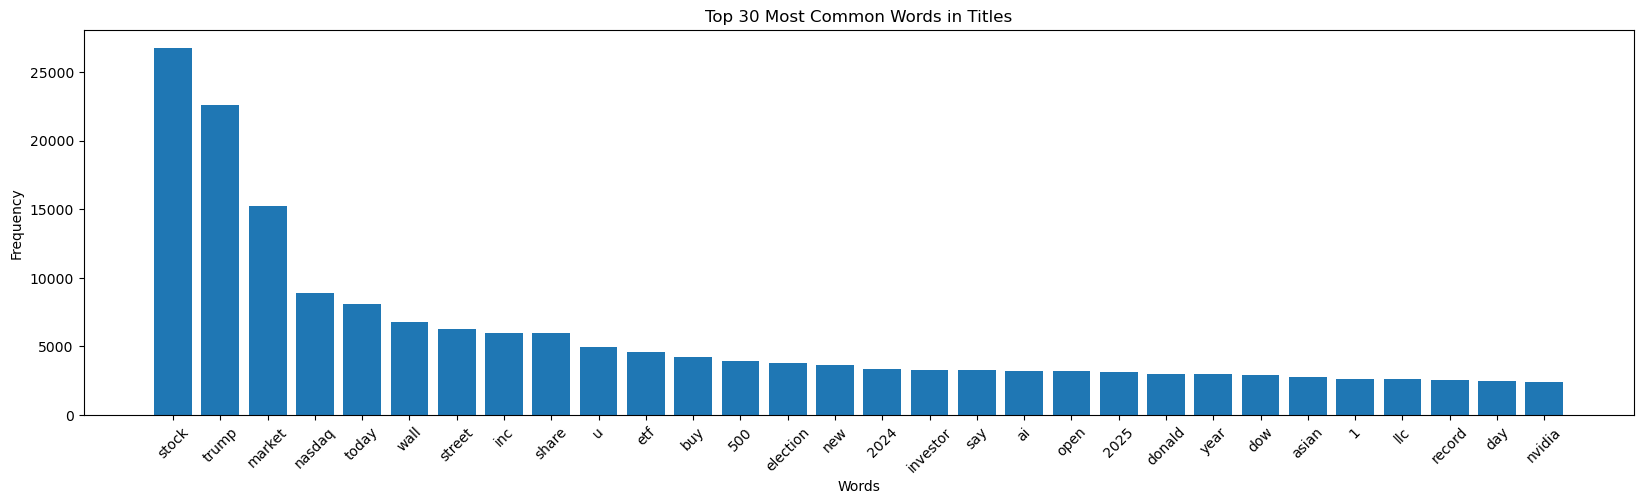

In [201]:
def get_word_frequencies(text_series):
    all_words = " ".join(text_series).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(30)

word_freq = get_word_frequencies(df_news_cleaned["cleaned_title"])

words, counts = zip(*word_freq)
plt.figure(figsize=(20,5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 30 Most Common Words in Titles")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [202]:
# Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df_news_cleaned["sentiment_score"] = df_news_cleaned["cleaned_title"].apply(get_sentiment)

In [203]:
def categorize_sentiment(score):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"

df_news_cleaned["sentiment_label"] = df_news_cleaned["sentiment_score"].apply(categorize_sentiment)

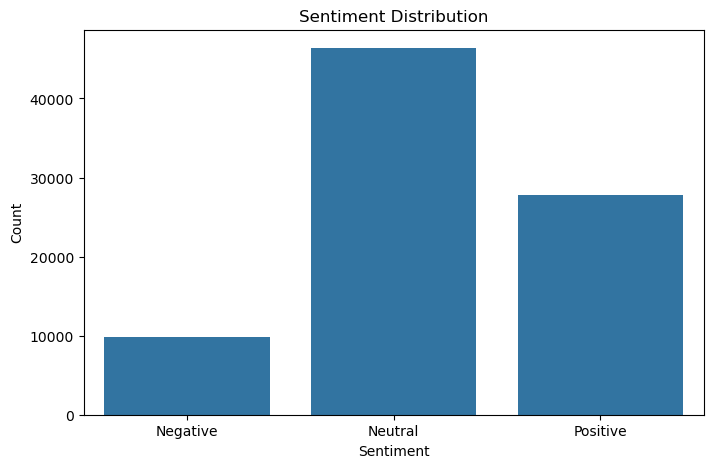

In [ ]:
# Sentiment Distribution Plot
plt.figure(figsize=(8, 5))
sns.countplot(x=df_news_cleaned["sentiment_label"].sort_values())
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

Most of the news articles are neutral, meaning they likely report facts rather than strong opinions. There's more positive sentiment than negative, suggesting that media coverage leans slightly optimistic or focuses on encouraging narratives rather than critical or alarming ones.

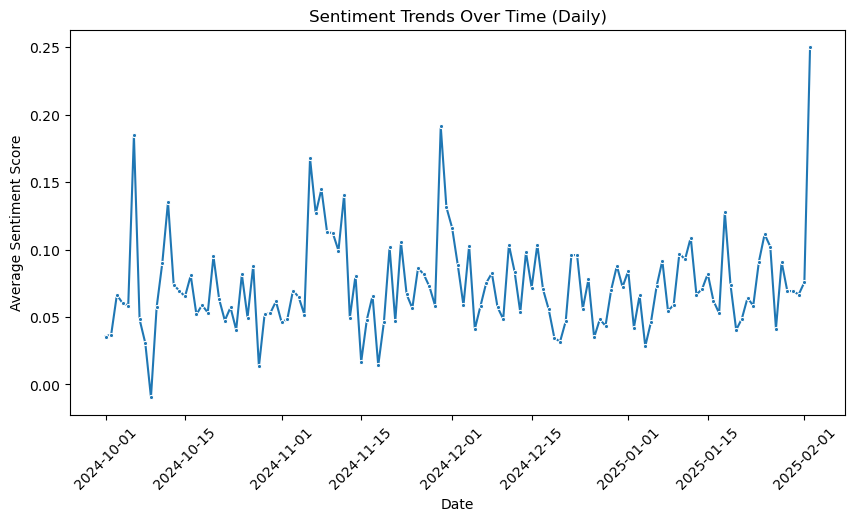

In [205]:
# Extract date from seenDate column
df_news_cleaned["date"] = df_news_cleaned["seenDate"].dt.date

# Sentiment Trends Over Time
sentiment_trend = df_news_cleaned.groupby("date")["sentiment_score"].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=sentiment_trend.index, y=sentiment_trend.values, marker=".")
plt.xticks(rotation=45)
plt.title("Sentiment Trends Over Time (Daily)")
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.show()


The news sentiment goes up and down, with some days being more positive and others more negative. Overall, it stays mostly positive, but there are a few drops, likely when big negative events happened.

We have completed basic analysis and EDA for news dataset. Let us move on to stock market dataset. We have three files here as well - one for each of nasdaq, dow jones and S&P 500.


In [206]:
df_stock_DJ = pd.read_csv('dataset_stock/Dow_Jones_Stock_Data.csv')
df_stock_DJ = df_stock_DJ.drop([0,1])
df_stock_DJ = df_stock_DJ.rename(columns={'Price': 'Date', 'Close': 'ClosingPrice', 'High': 'HighPrice', 'Low':'LowPrice', 'Open':'OpenPrice'})
df_stock_DJ['Stock'] = 'DowJones'
print(df_stock_DJ.shape)
df_stock_DJ.head()

(580, 7)


,Date,ClosingPrice,HighPrice,LowPrice,OpenPrice,Volume,Stock
2,2024-10-01 13:30:00+00:00,42014.6796875,42268.0,41945.62890625,42262.96875,0,DowJones
3,2024-10-01 14:30:00+00:00,42126.1796875,42132.7109375,41965.03125,42015.51171875,40888703,DowJones
4,2024-10-01 15:30:00+00:00,42179.48046875,42233.6015625,42115.96875,42125.140625,30669078,DowJones
5,2024-10-01 16:30:00+00:00,42013.05859375,42182.2890625,42001.55859375,42179.75,32518258,DowJones
6,2024-10-01 17:30:00+00:00,42304.859375,42310.69921875,42003.66015625,42012.87109375,30396750,DowJones


In [207]:
df_stock_Nasdaq = pd.read_csv('dataset_stock/Nasdaq_Stock_Data.csv')
df_stock_Nasdaq['Stock'] = 'Nasdaq'
print(df_stock_Nasdaq.shape)
df_stock_Nasdaq.head()

(582, 7)


,Price,Close,High,Low,Open,Volume,Stock
0,Ticker,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC,Nasdaq
1,Datetime,NaN,NaN,NaN,NaN,NaN,Nasdaq
2,2024-10-01 13:30:00+00:00,17851.95703125,18162.369140625,17836.49609375,18157.359375,0,Nasdaq
3,2024-10-01 14:30:00+00:00,17842.892578125,17895.61328125,17787.228515625,17847.03515625,683314000,Nasdaq
4,2024-10-01 15:30:00+00:00,17897.421875,17927.939453125,17836.068359375,17841.212890625,501870000,Nasdaq


In [208]:
df_stock_SNP = pd.read_csv('dataset_stock/S&P_500_Stock_Data.csv')
df_stock_SNP['Stock'] = 'S&P500'
print(df_stock_SNP.shape)
df_stock_SNP.head()

(582, 7)


,Price,Close,High,Low,Open,Volume,Stock
0,Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,S&P500
1,Datetime,NaN,NaN,NaN,NaN,NaN,S&P500
2,2024-10-01 13:30:00+00:00,5695.5498046875,5757.72998046875,5689.68994140625,5757.72998046875,0,S&P500
3,2024-10-01 14:30:00+00:00,5700.759765625,5708.2998046875,5682.35986328125,5695.6201171875,314183931,S&P500
4,2024-10-01 15:30:00+00:00,5708.91015625,5716.8701171875,5698.47998046875,5700.5400390625,228816929,S&P500


In [209]:
print(df_stock_DJ.columns)
print(df_stock_Nasdaq.columns)
print(df_stock_SNP.columns)


Index(['Date', 'ClosingPrice', 'HighPrice', 'LowPrice', 'OpenPrice', 'Volume',
       'Stock'],
      dtype='object')
Index(['Price', 'Close', 'High', 'Low', 'Open', 'Volume', 'Stock'], dtype='object')
Index(['Price', 'Close', 'High', 'Low', 'Open', 'Volume', 'Stock'], dtype='object')


In [210]:
standard_columns = ["Date", "ClosingPrice", "HighPrice", "LowPrice", "OpenPrice", "Volume", "Stock"]

df_stock_Nasdaq.rename(columns={"Price": "Date", "Close": "ClosingPrice", "High": "HighPrice", 
                                 "Low": "LowPrice", "Open": "OpenPrice"}, inplace=True)

df_stock_SNP.rename(columns={"Price": "Date", "Close": "ClosingPrice", "High": "HighPrice", 
                              "Low": "LowPrice", "Open": "OpenPrice"}, inplace=True)

df_stock_DJ.columns = standard_columns
df_stock_Nasdaq.columns = standard_columns
df_stock_SNP.columns = standard_columns

# Concatenate all three datasets
df_stock = pd.concat([df_stock_DJ, df_stock_Nasdaq, df_stock_SNP], axis=0, ignore_index=True)

print(df_stock.head())


                        Date    ClosingPrice       HighPrice        LowPrice  \
0  2024-10-01 13:30:00+00:00   42014.6796875         42268.0  41945.62890625   
1  2024-10-01 14:30:00+00:00   42126.1796875   42132.7109375     41965.03125   
2  2024-10-01 15:30:00+00:00  42179.48046875   42233.6015625     42115.96875   
3  2024-10-01 16:30:00+00:00  42013.05859375   42182.2890625  42001.55859375   
4  2024-10-01 17:30:00+00:00    42304.859375  42310.69921875  42003.66015625   

        OpenPrice    Volume     Stock  
0     42262.96875         0  DowJones  
1  42015.51171875  40888703  DowJones  
2    42125.140625  30669078  DowJones  
3        42179.75  32518258  DowJones  
4  42012.87109375  30396750  DowJones  


In [211]:
#Lets inspect the dataset
print(df_stock.shape)
df_stock.describe()

(1744, 7)


,Date,ClosingPrice,HighPrice,LowPrice,OpenPrice,Volume,Stock
count,1744,1742,1742,1742,1742,1742,1744
unique,582,1737,1732,1736,1740,1501,3
top,2024-10-01 13:30:00+00:00,6047.06005859375,6077.7099609375,6085.02001953125,42125.140625,0,Nasdaq
freq,3,2,2,2,2,242,582


In [212]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          1744 non-null   object
 1   ClosingPrice  1742 non-null   object
 2   HighPrice     1742 non-null   object
 3   LowPrice      1742 non-null   object
 4   OpenPrice     1742 non-null   object
 5   Volume        1742 non-null   object
 6   Stock         1744 non-null   object
dtypes: object(7)
memory usage: 95.5+ KB


In [213]:
#we see all the columns which were supposed to be numeric are represented as object. lets convert them (except date and stock)

cols_to_convert = ["ClosingPrice", "HighPrice", "LowPrice", "OpenPrice", "Volume"]
df_stock[cols_to_convert] = df_stock[cols_to_convert].apply(pd.to_numeric, errors="coerce")

print(df_stock.dtypes) 

Date             object
ClosingPrice    float64
HighPrice       float64
LowPrice        float64
OpenPrice       float64
Volume          float64
Stock            object
dtype: object


In [214]:
#Sort the dataset according to date

df_stock["Date"] = pd.to_datetime(df_stock["Date"], errors="coerce")

df_stock = df_stock.sort_values(by="Date", ascending=True)

df_stock = df_stock.reset_index(drop=True)

# Verify the sorting
print(df_stock.head())
print(df_stock.tail())


                       Date  ClosingPrice     HighPrice      LowPrice  \
0 2024-10-01 13:30:00+00:00  42014.679688  42268.000000  41945.628906   
1 2024-10-01 13:30:00+00:00   5695.549805   5757.729980   5689.689941   
2 2024-10-01 13:30:00+00:00  17851.957031  18162.369141  17836.496094   
3 2024-10-01 14:30:00+00:00  42126.179688  42132.710938  41965.031250   
4 2024-10-01 14:30:00+00:00   5700.759766   5708.299805   5682.359863   

      OpenPrice       Volume     Stock  
0  42262.968750          0.0  DowJones  
1   5757.729980          0.0    S&P500  
2  18157.359375          0.0    Nasdaq  
3  42015.511719   40888703.0  DowJones  
4   5695.620117  314183931.0    S&P500  
                          Date  ClosingPrice    HighPrice     LowPrice  \
1739 2025-01-31 20:30:00+00:00   6040.069824  6051.970215  6030.930176   
1740                       NaT           NaN          NaN          NaN   
1741                       NaT           NaN          NaN          NaN   
1742               

In [215]:
#There are few values in date column which do not make sense. Lets remove them
df_stock = df_stock.dropna(subset=["Date"])
df_stock.tail(15)

,Date,ClosingPrice,HighPrice,LowPrice,OpenPrice,Volume,Stock
1725,2025-01-31 16:30:00+00:00,44935.878906,44944.488281,44832.328125,44874.148438,70920910.0,DowJones
1726,2025-01-31 16:30:00+00:00,19941.644531,19941.644531,19886.248047,19920.507812,788409000.0,Nasdaq
1727,2025-01-31 16:30:00+00:00,6116.160156,6116.189941,6101.839844,6111.250000,288493268.0,S&P500
1728,2025-01-31 17:30:00+00:00,19833.066406,19946.048828,19830.025391,19942.134766,594075000.0,Nasdaq
1729,2025-01-31 17:30:00+00:00,6088.209961,6117.970215,6087.729980,6116.259766,256063000.0,S&P500
1730,2025-01-31 17:30:00+00:00,44737.941406,44955.058594,44723.839844,44935.570312,52392499.0,DowJones
1731,2025-01-31 18:30:00+00:00,19735.583984,19840.199219,19703.822266,19827.578125,715019000.0,Nasdaq
1732,2025-01-31 18:30:00+00:00,6065.410156,6089.890137,6054.549805,6088.359863,306245000.0,S&P500
1733,2025-01-31 18:30:00+00:00,44651.800781,44738.621094,44532.578125,44738.621094,63825398.0,DowJones
1734,2025-01-31 19:30:00+00:00,6036.790039,6070.700195,6034.479980,6065.439941,340780000.0,S&P500


In [216]:
#Lets check if there are any missing values in any column.
#There are no missing values, so we are good. 

for col in df_stock.columns:
    null_count = df_stock[col].isnull().sum()
    print(f"Number of null values in column {col}: {null_count}")

Number of null values in column Date: 0
Number of null values in column ClosingPrice: 0
Number of null values in column HighPrice: 0
Number of null values in column LowPrice: 0
Number of null values in column OpenPrice: 0
Number of null values in column Volume: 0
Number of null values in column Stock: 0


In [217]:
#Let us plot the closing prices of all three indices (Dow Jones, NASDAQ, S&P 500) to understand their trends.

fig = px.line(df_stock, x="Date", y="ClosingPrice", color="Stock",
              title="Stock Market Trends Over Time",
              labels={"ClosingPrice": "Closing Price", "Date": "Date"},
              template="plotly_dark")

fig.show()


The Dow Jones, Nasdaq, and S&P 500 all show relatively stable trends over time, with small fluctuations but no major crashes. The Dow Jones is the highest, followed by Nasdaq and then S&P 500, reflecting their typical market levels.

In [218]:
#Let us measure daily stock market changes to see fluctuations.

df_stock["Daily_Return"] = df_stock.groupby("Stock")["ClosingPrice"].pct_change()
df_stock_cleaned = df_stock.dropna(subset=["Daily_Return"])

fig = px.line(df_stock_cleaned, x="Date", y="Daily_Return", color="Stock",
              title="Stock Market Daily Returns",
              labels={"Daily_Return": "Daily Return (%)", "Date": "Date"},
              template="plotly_dark")

fig.show()


This plot shows the daily returns of the Dow Jones, S&P 500, and Nasdaq indices over time, with fluctuations indicating market volatility. The Nasdaq appears to have the highest variability, while all three indices generally follow similar trends with occasional sharp spikes or drops.

In [ ]:
#lets calculate market volatality using Rolling Standard Deviation
# Calculating 50-day rolling volatility

df_stock["Volatility"] = df_stock.groupby("Stock")["Daily_Return"].rolling(window=50).std().reset_index(level=0, drop=True)

df_stock_cleaned = df_stock.dropna(subset=["Volatility"])

fig = px.line(df_stock_cleaned, x="Date", y="Volatility", color="Stock",
              title="Stock Market Volatility (50-day Rolling)",
              labels={"Volatility": "Volatility (Rolling Std Dev)", "Date": "Date"},
              template="plotly_dark")

fig.show()


This chart shows how bumpy the stock market has been over time. Nasdaq has the biggest ups and downs, while the other two are a bit steadier, but all of them get shakier as time goes on.

In [233]:
#We have completed the EDA on stock market data, lets merge sentiment analysis dataset with stock market dataset
#Since they are ordered by date, lets make sure date is in same format in both the datasets

df_news_cleaned['Date'] = pd.to_datetime(df_news_cleaned["seenDate"]).dt.date
df_stock_cleaned["Date"] = pd.to_datetime(df_stock_cleaned["Date"]).dt.date

df_news_cleaned


/var/folders/55/x837yjcj345fvyz78_wh348h0000gn/T/ipykernel_19822/1797302149.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,title,seenDate,domain,language,sourceCountry,title_length,hour,cleaned_title,sentiment_score,sentiment_label,date,Date
0,Advisory Alpha LLC Increases Stock Position in...,2024-10-01 20:30:00,tickerreport.com,English,United States,110,20,advisory alpha llc increase stock position spd...,-0.150000,Negative,2024-10-01,2024-10-01
1,Iran readying imminent ballistic missile att...,2024-10-01 14:45:00,nbcnewyork.com,English,United States,113,14,iran readying imminent ballistic missile attac...,0.136364,Positive,2024-10-01,2024-10-01
2,Stock futures are little changed following roc...,2024-10-01 22:30:00,nbclosangeles.com,English,United States,80,22,stock future little changed following rocky st...,-0.012784,Negative,2024-10-01,2024-10-01
3,Stock futures are little changed following roc...,2024-10-01 22:30:00,nbcconnecticut.com,English,United States,80,22,stock future little changed following rocky st...,-0.012784,Negative,2024-10-01,2024-10-01
4,Dow notches another closing record after encou...,2024-10-01 01:00:00,insurancenewsnet.com,English,United States,66,1,dow notch another closing record encouraging p...,0.000000,Neutral,2024-10-01,2024-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...
85508,El Salvador Revises Bitcoin Strategy for $1 . ...,2025-01-30 14:45:00,banklesstimes.com,English,United States,64,14,el salvador revise bitcoin strategy 1 4 billio...,0.000000,Neutral,2025-01-30,2025-01-30
85509,Exco Technologies Limited Announces Results fo...,2025-01-30 01:15:00,forextv.com,English,United States,86,1,exco technology limited announces result first...,0.089286,Positive,2025-01-30,2025-01-30
85510,January 2025 Ballot Access News Print Edition,2025-01-30 02:30:00,ballot-access.org,English,United States,45,2,january 2025 ballot access news print edition,0.000000,Neutral,2025-01-30,2025-01-30
85511,US SEC Gives Initial Approval to Combined Bitc...,2025-01-31 09:30:00,finance.yahoo.com,English,United States,61,9,u sec give initial approval combined bitcoin e...,-0.050000,Negative,2025-01-31,2025-01-31


In [234]:
df_sentiment_daily = df_news_cleaned.groupby("Date")["sentiment_score"].mean().reset_index()
df_sentiment_daily["news_count"] = df_news_cleaned.groupby("Date")["title"].count().reset_index()["title"]
df_sentiment_daily

,Date,sentiment_score,news_count
0,2024-10-01,0.035543,742
1,2024-10-02,0.037017,667
2,2024-10-03,0.066424,758
3,2024-10-04,0.060282,796
4,2024-10-05,0.058526,656
...,...,...,...
120,2025-01-29,0.069217,682
121,2025-01-30,0.069237,681
122,2025-01-31,0.066657,694
123,2025-02-01,0.075764,619


In [235]:
#Merge stock market data with sentiment data on Date. We are using a left join
df_final = df_stock_cleaned.merge(df_sentiment_daily, on="Date", how="left")
df_final.head()

,Date,ClosingPrice,HighPrice,LowPrice,OpenPrice,Volume,Stock,Daily_Return,Volatility,sentiment_score,news_count
0,2024-10-07,42105.261719,42220.980469,42060.988281,42218.761719,23941878.0,DowJones,-0.002677,0.002530,0.048191,736
1,2024-10-07,5729.930176,5737.779785,5722.270020,5737.020020,213956436.0,S&P500,-0.001227,0.002261,0.048191,736
2,2024-10-07,18068.437500,18090.697266,18042.160156,18079.615234,465837000.0,Nasdaq,-0.000594,0.002843,0.048191,736
3,2024-10-07,42103.781250,42142.140625,42080.019531,42105.449219,19754527.0,DowJones,-0.000035,0.002483,0.048191,736
4,2024-10-07,5724.669922,5730.470215,5723.100098,5730.009766,169520701.0,S&P500,-0.000918,0.002266,0.048191,736


In [236]:
#lets check if there are any missing values in our final dataset
df_final.isnull().sum()


Date               0
ClosingPrice       0
HighPrice          0
LowPrice           0
OpenPrice          0
Volume             0
Stock              0
Daily_Return       0
Volatility         0
sentiment_score    0
news_count         0
dtype: int64

In [ ]:
# Compute correlation matrix
correlation_matrix = df_final[["ClosingPrice", "Daily_Return", "Volatility", "sentiment_score", "news_count"]].corr()
print(correlation_matrix)

                 ClosingPrice  Daily_Return  Volatility  sentiment_score  \
ClosingPrice         1.000000      0.001247   -0.102604         0.009215   
Daily_Return         0.001247      1.000000    0.083377         0.076304   
Volatility          -0.102604      0.083377    1.000000         0.197550   
sentiment_score      0.009215      0.076304    0.197550         1.000000   
news_count          -0.009341      0.020611    0.083658         0.197366   

                 news_count  
ClosingPrice      -0.009341  
Daily_Return       0.020611  
Volatility         0.083658  
sentiment_score    0.197366  
news_count         1.000000  


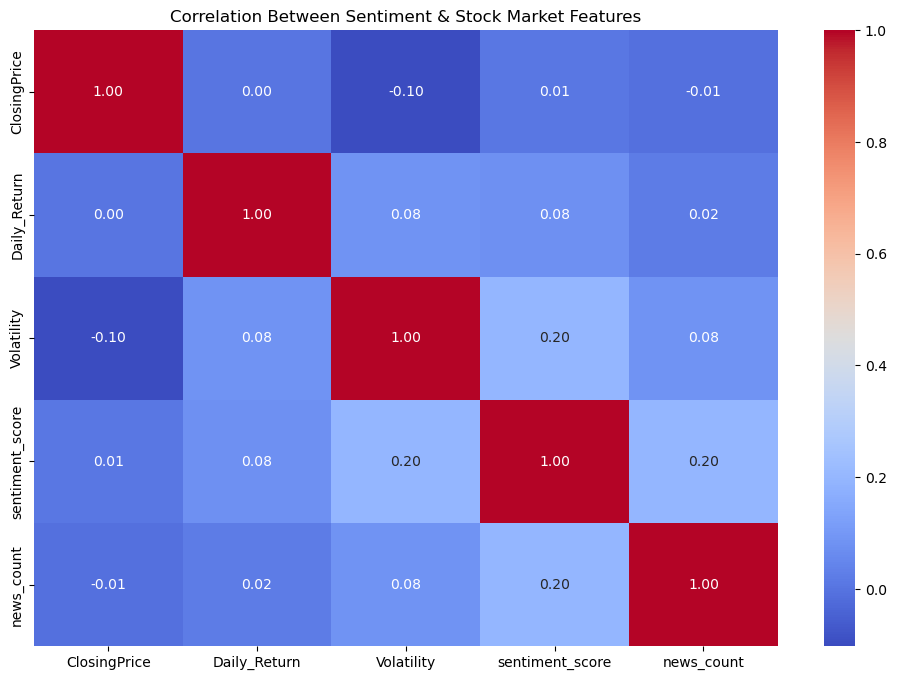

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Sentiment & Stock Market Features")
plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_final["Date"],
    y=df_final["ClosingPrice"],
    mode="lines",
    name="Stock Closing Price",
    line=dict(color="blue")
))

fig.add_trace(go.Scatter(
    x=df_final["Date"],
    y=df_final["sentiment_score"],
    mode="lines",
    name="Sentiment Score",
    line=dict(color="red"),
    yaxis="y2" 
))

fig.update_layout(
    title="Stock Prices vs. Sentiment Score Over Time",
    xaxis=dict(title="Date"),
    yaxis=dict(title="Stock Price", titlefont=dict(color="blue"), tickfont=dict(color="blue")),
    yaxis2=dict(title="Sentiment Score", titlefont=dict(color="red"), tickfont=dict(color="red"),
                overlaying="y", side="right"), 
    legend=dict(x=0, y=1)
)
fig.show()


In [247]:
#Lets see if sentiment impacts volatality
df_final["Sentiment_Volatility"] = df_final["sentiment_score"].rolling(window=7).std()

fig = px.line(df_final, x="Date", y=["Volatility", "Sentiment_Volatility"],
              title="Stock Market Volatility vs. Sentiment Volatility",
              labels={"value": "Volatility", "Date": "Date"})
fig.show()


While the market moves more steadily, people's emotions and reactions to news are all over the place, with big spikes that might influence stock movements.

Now we are done with EDA, lets start with a baseline model. We want to predict whether the stock price will go up or down based on sentiment .

In [258]:
df_final["Stock_Movement"] = (df_final["Daily_Return"] > 0).astype(int)

features = ["sentiment_score", "news_count", "Volatility"]
X = df_final[features]
y = df_final["Stock_Movement"]

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We will use a Random Forest Classifier since it handles both non-linear relationships and feature importance well.

In [ ]:
# Train a baseline Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))


Baseline Model Accuracy: 0.51
              precision    recall  f1-score   support

           0       0.49      0.43      0.46       158
           1       0.53      0.59      0.56       172

    accuracy                           0.51       330
   macro avg       0.51      0.51      0.51       330
weighted avg       0.51      0.51      0.51       330



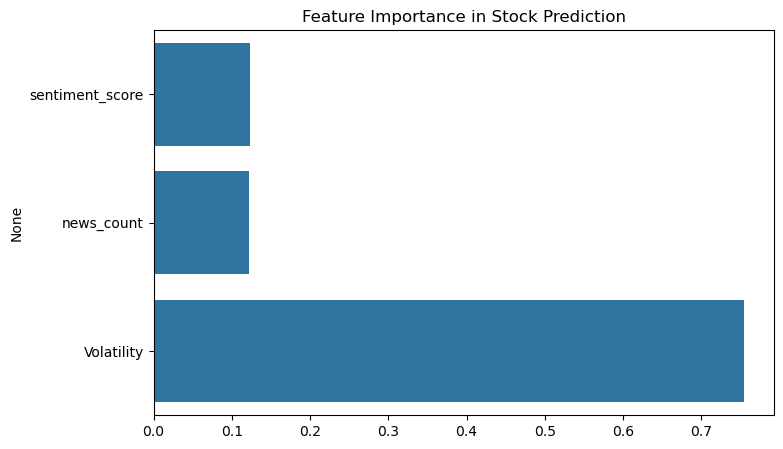

In [ ]:
#Lets check feature importance
feature_importances = model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances, y=feature_names)
plt.title("Feature Importance in Stock Prediction")
plt.show()

Volatility is the biggest driver, while news count and sentiment score have some influence but are much less important in comparison.